In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import rpy2.robjects as robj
import pyreadr
from easydict import EasyDict as edict
from tqdm import tqdm_notebook as tqdm
import sys
import time as Time
import pickle
from scipy.io import loadmat
from scipy.signal import decimate, detrend
import seaborn as sns
%matplotlib inline

In [2]:
sys.path.append("/home/huaqingj/MyResearch/dynamicR2py")
from utils import *

In [3]:
MEG = loadmat("./data/subj1.mat")["DK_timecourse"]

In [4]:
kappa = 2.65
r = 6
Lmin = 60
# Down sample rate when estimating A matrix
downrate = 20 
#Rate when doing decimate 
rate = 10 
MaxM = 20
lamb = 1e-4
fct = 0.5

In [5]:
#MEG = detrend(MEG) # The data are already detrended
MEG = decimate(MEG, q=rate)

In [6]:
d, n = MEG.shape
time = np.linspace(0, 2, n)

In [12]:
t0 = Time()
dXmat, Xmat = GetBsplienEst(MEG, time, lamb=lamb)
Amat = GetAmat(dXmat, Xmat, time, downrate, fct=fct)
midRes = GetNewEst(dXmat, Xmat, Amat, r=r, is_full=True)
ndXmat, nXmat = midRes.ndXmat, midRes.nXmat
finalRes = EGenDy(ndXmat, nXmat, kappa=kappa, Lmin=Lmin, MaxM=MaxM, diag=True)
tc = Time()

In [48]:
MEG1Res = edict()
MEG1Res.PostMEG = MEG
MEG1Res.midRes = midRes
MEG1Res.finalRes = finalRes
MEG1Res.Amat = Amat
MEG1Res.dXmat = dXmat
MEG1Res.Xmat = Xmat
paras = {"kappa":kappa, "Lmin":Lmin, "r":r, "downrate":downrate, "MaxM":MaxM, "lamb":lamb, "rate":rate}

In [49]:
with open("./results/MEG1Res.pkl", "wb") as f:
    pickle.dump(MEG1Res, f)

In [7]:
with open("./results/MEG1Res.pkl", "rb") as f:
    MEG1Res = pickle.load(f)

In [9]:
MEG1Res.finalRes.mbic_ecpts.shape

(12,)

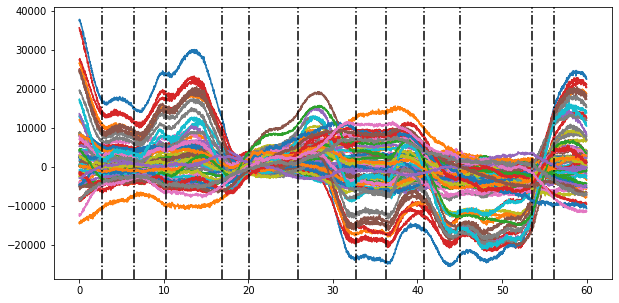

In [10]:
plt.figure(figsize=[10, 5])
ptime = np.linspace(0, 60, n)
for i in range(d):
    plt.plot(ptime, MEG[i, :], "-")
for ecpt in MEG1Res.finalRes.mbic_ecpts:
    plt.axvline(ecpt/60, color="black", linestyle="-.")

### Plot the Reconstructed Curve

In [11]:
finalRes = MEG1Res.finalRes
midRes = MEG1Res.midRes
t0 = Time()
tStep = np.diff(time)[0]
ecpts = finalRes.mbic_ecpts
ndXmat = midRes.ndXmat
nXmat = midRes.nXmat
kpidxs = midRes.kpidxs
eigVecs = midRes.eigVecs
RecRes = ReconXmat(ecpts, ndXmat, nXmat, kpidxs, eigVecs, MEG, tStep, is_full=True) 
RecMEG = RecRes.EstXmatReal
tc = Time()
print(f"The consumed time is {tc-t0:.2f}s.")

The consumed time is 26.45s.


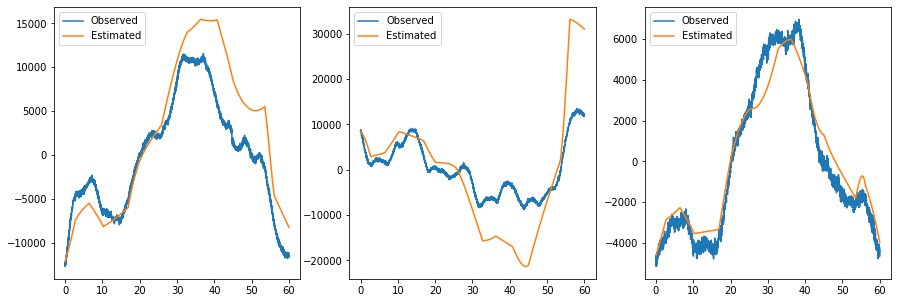

In [12]:
ptime = np.linspace(0, 60, n)
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.plot(ptime, MEG[66, :], label="Observed")
plt.plot(ptime, RecMEG[66, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 2)
plt.plot(ptime, MEG[47, :], label="Observed")
plt.plot(ptime, RecMEG[47, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ptime, MEG[52, :], label="Observed")
plt.plot(ptime, RecMEG[52, :], label="Estimated")
_ = plt.legend()

In [40]:
freq = 60 
ReLamMs = RecRes.LamMs.real*freq/30 
ImLamMs = RecRes.LamMs.imag*freq /(30*2*np.pi)

In [75]:
linestyles = [  ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))] 
cols = sns.color_palette("Paired", 6)
#cols = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

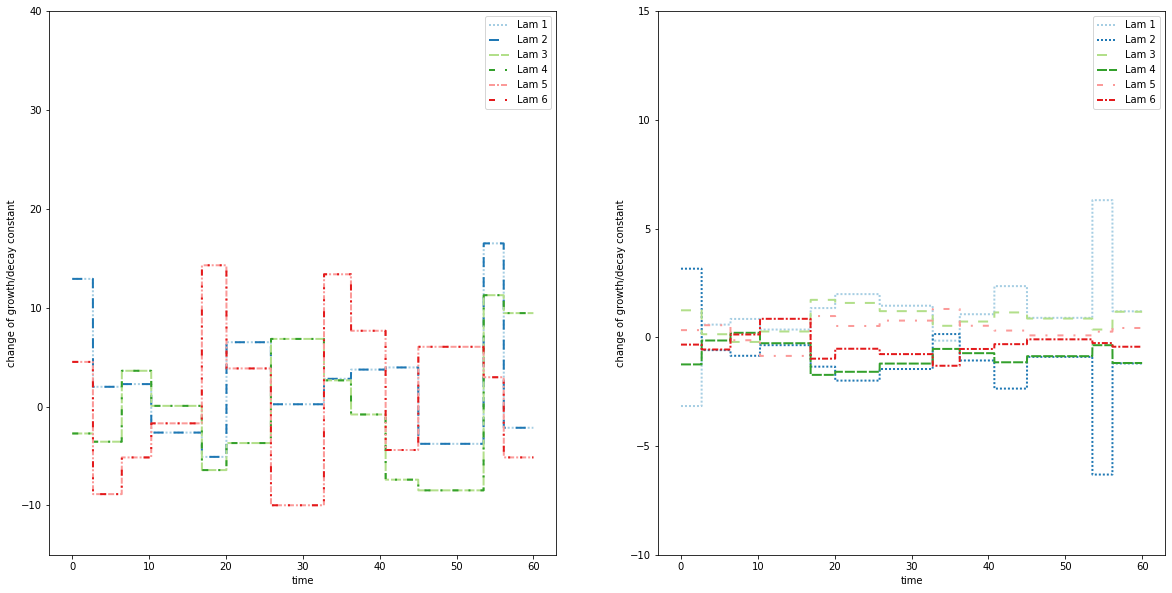

In [78]:
plt.figure(figsize=[20,10])

plt.subplot(121)
for i in range(ReLamMs.shape[0]):
    plt.plot(ptime, ReLamMs[i, :], label=f"Lam {i+1}", linestyle=linestyles[i+1][-1], color=cols[i], linewidth=2)
plt.ylim([-15, 40])
plt.ylabel("change of growth/decay constant")
plt.xlabel("time")
_ = plt.legend()

plt.subplot(122)
for i in range(ReLamMs.shape[0]):
    plt.plot(ptime, ImLamMs[i, :], label=f"Lam {i+1}", linestyle=linestyles[i][-1], color=cols[i], linewidth=2)
plt.ylim([-10, 15])
plt.ylabel("change of growth/decay constant")
plt.xlabel("time")
_ = plt.legend()